In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
tfd=tfp.distributions
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tqdm import notebook
from sklearn.model_selection import KFold


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
%matplotlib inline

### Load Data

In [17]:
train=np.load('Train.npy')
test=np.load('Test.npy')

train_x=train[:,:-1]
train_y=train[:,-1].reshape(-1,1)*4.  #to avoid to small a variability

test_x=test[:,:-1]
test_y=test[:,-1].reshape(-1,1)*4.  #to avoid to small a variability 

ntrain=len(train_x)
ntest=len(test_x)


Code refer to {https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net}

###  MC-Dropout(DP)

#### normalization function

In [ ]:
##define a normalization function
def norm_data(train, test,norm=True):
    std_train=np.ones(train.shape[1])
    mu_train=np.zeros(train.shape[1])
    if(norm):
        std_train = np.std(train, 0)
        mu_train=np.mean(train,0)

    train=(train - np.full(train.shape, mu_train)) / \
            np.full(train.shape, std_train)
    test=(test - np.full(test.shape, mu_train)) / \
            np.full(test.shape, std_train)
    return train,test,mu_train,std_train

In [ ]:

# train_x,test_x,_,_=norm_data(train_x,test_x,norm=False)
# train_y,_,muy,stdy=norm_data(train_y,test_y,norm=False)

### define model

In [15]:
class MCdp:
    def __init__(self,tau,dropout):
        self.tau=tau
        self.dropout=dropout

    #use normal approximation for output, by drawing 1000 samples
    def model_musd(self,trainx,trainy,testx):    
        # construct the network
        N = len(trainx)
        batch_size = 128
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - self.dropout) / (2. * N * self.tau)
        inputs = Input(shape=(train_x.shape[1],))
        inter = Dropout(self.dropout)(inputs, training=True)
        inter = Dense(100, activation='relu',kernel_regularizer=l2(reg))(inputs)
        inter = Dropout(self.dropout)(inter, training=True)
        inter = Dense(50, activation='relu',kernel_regularizer=l2(reg))(inter)
        inter = Dropout(self.dropout)(inter, training=True)
        outputs = Dense(1,kernel_regularizer=l2(reg))(inter)
        model= Model(inputs,outputs)
        opt = keras.optimizers.Adam()
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.fit(train_x, train_y, batch_size=batch_size, epochs=300, verbose=0)

        #generate 1000 posterior samples
        ntest=len(testx)
        Yt_hat=np.zeros((1000,ntest))
        for t in notebook.tnrange(1000):
            mu=model.predict(testx, batch_size=128,verbose=0).ravel() 
            Yt_hat[t,:] = mu
        MC_pred=np.mean(Yt_hat, 0)

        MC_std=np.sqrt(np.diag((Yt_hat.T@Yt_hat)/1000)-MC_pred**2+1./self.tau)
        return MC_pred, MC_std



#### 5-fold cross validation for parameter tuning

In [ ]:
tauval=[0.25,0.5,0.75]
dpval=[0.01,0.05,0.1]
hyperparam=np.zeros((9,2))
hyperparam[:,0]=np.repeat(tauval,3)
hyperparam[:,1]=np.tile(dpval,3)

In [ ]:
## create 5 folds
id = np.arange(len(train_x))
kf = KFold(n_splits=5)
tuneresult=[]


for i in range(len(hyperparam)):
    
    ## tuning parameter
    tautmp=hyperparam[i,0]
    dptmp=hyperparam[i,1]

    for trainid, testid in kf.split(id):
        mcdptmp=MCdp(tautmp,dptmp)
        mutmp,stdtmp=mcdptmp.model_musd(train_x[trainid],train_y[trainid],train_x[testid])

        ## extract validation y
        testytmp=train_y[testid]
           
        ##likelihood
        low=np.quantile(testytmp,0.05)
        high=np.quantile(testytmp,0.95)
        itv=np.linspace(low,high,9)
        itv=np.append(-np.infty,itv)
        itv=np.append(itv,np.infty)
        #outcome1 belongs to which interval
        ids=np.zeros(len(testytmp))
        for i in range(10):
            ids=ids+1*(testytmp.ravel()>itv[i+1])
        ids=ids.astype('int')
        

        l=(itv[ids]-mutmp)/stdtmp
        r=(itv[ids+1]-mutmp)/stdtmp
        prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
        ll_est=np.log(prtmp+1.e-10)
        
        tuneresult.append(ll_est.mean())            



In [ ]:
list(zip([np.mean(tuneresult[i*5:(i+1)*5]) for i in range(9)],hyperparam))

[(-1.7721469186731633, array([0.25, 0.01])),
 (-1.774580436555148, array([0.25, 0.05])),
 (-1.7772357505171101, array([0.25, 0.1 ])),
 (-1.4893965247535113, array([0.5 , 0.01])),
 (-1.4967457065821215, array([0.5 , 0.05])),
 (-1.4989111860132514, array([0.5, 0.1])),
 (-1.3277719834254322, array([0.75, 0.01])),
 (-1.3370775597272768, array([0.75, 0.05])),
 (-1.3417565194167138, array([0.75, 0.1 ]))]

### We choose tau=0.75,dp=0.01 as the best tunning parameter for model fitting

In [19]:
mcdptuned=MCdp(0.75,0.01)

dpmu,dpstd=mcdptuned.model_musd(train_x,train_y,test_x)



## evaluation

### median by MAE

In [20]:
np.abs(dpmu-test_y.ravel()).mean()/4.

0.12457871717346787

### calibration

In [21]:
per=np.linspace(0.02,0.98,8)

In [22]:
#generate confidence interval through sampling to approximate asymptotic distribution
dpc=[]

per=np.linspace(0.02,0.98,8)
for i in per:
    lquantile=(stats.norm.ppf(0.5-i/2.)*dpstd+dpmu)
    rquantile=(stats.norm.ppf(0.5+i/2.)*dpstd+dpmu)
    dpc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

l90=(stats.norm.ppf(0.5-0.9/2.)*dpstd+dpmu)
r90=(stats.norm.ppf(0.5+0.9/2.)*dpstd+dpmu)
np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel()))    

0.9523809523809523

In [23]:
np.array(dpc),np.abs(dpc-per).mean()

(array([0.07142857, 0.44047619, 0.64285714, 0.79761905, 0.88095238,
        0.9047619 , 0.94047619, 0.97619048]), 0.207797619047619)

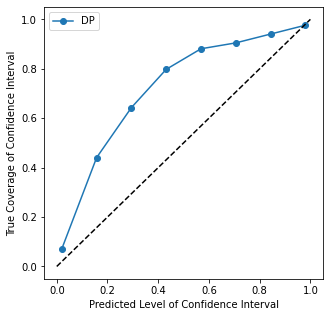

In [24]:
plt.plot(per,dpc,'o-',label='DP')
plt.xlabel('Predicted Level of Confidence Interval')
plt.ylabel('True Coverage of Confidence Interval')
plt.legend()
plt.plot([0,1],[0,1],'k--')
fig = plt.gcf()
fig.set_size_inches(5,5)

### log likelihood


In [25]:
##likelihood
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(len(test_y))
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')

In [26]:

l=(itv[id]-dpmu)/dpstd
r=(itv[id+1]-dpmu)/dpstd
prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
ll_est=np.log(prtmp+1.e-10)
ll_est.mean()

-1.359402738732168

#### Interval width

In [27]:
dpwidth=np.median(dpstd)*stats.norm.ppf(per/2+0.5)*2./4.
dpwidth

array([0.0144996 , 0.11466006, 0.2184104 , 0.32977269, 0.45504766,
       0.60659547, 0.81827459, 1.34553536])

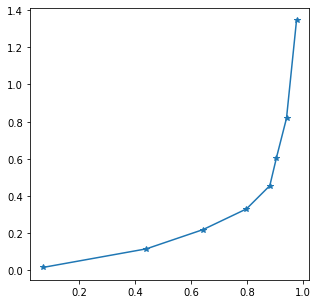

In [43]:
### sharpness plot
plt.figure(figsize=(5,5))
plt.plot(dpc,dpwidth,'-*')

### calibration the coverage with CR, split the training into training and calibration (7/3)

In [50]:
id0=np.random.choice(ntrain,int(0.7*ntrain),replace=False)

In [51]:
id1=np.array([i for i in np.arange(ntrain) if i not in id0])

In [52]:
train_xnew=train_x[id0]
cal_x=train_x[id1]
train_ynew=train_y[id0,:]
cal_y=train_y[id1,:]
ncal=len(cal_x)

In [55]:
mcdptuned=MCdp(0.75,0.01)
mutmp,stdtmp=mcdptuned.model_musd(train_xnew,train_ynew,np.r_[cal_x,test_x])
mucal=mutmp[:ncal]
stdcal=stdtmp[:ncal]
dpmu=mutmp[ncal:]
dpstd=stdtmp[ncal:]

In [ ]:
### we calibrate based on 100 points

In [60]:
## proposed value are our nominal belif
proposep=np.linspace(0.01,0.99,100)
truep=[]
for i in proposep:
    outtmp=stats.norm.ppf(i)*stdcal+mucal
    truep.append((cal_y.ravel()<outtmp.ravel()).mean())
truep=np.append(0,truep)
truep=np.append(truep,1)

proposep=np.append(0,proposep)
proposep=np.append(proposep,1)



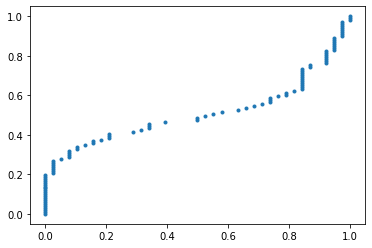

In [61]:
## the relationship between nominal vs empirical quantiles
plt.plot(truep,proposep,'.')

In [62]:
## use interpolation to learn the cr
from scipy.interpolate import interp1d


In [63]:
## match true with realized quantiles
cr= interp1d(truep, proposep)

In [64]:
## mae

np.abs(dpmu+dpstd*stats.norm.ppf(cr(0.5))-test_y.ravel()).mean()/4.

0.12330806322279148

In [75]:
##recalculate calibration
dpcrc=[]

per=np.linspace(0.02,0.98,8)
for i in per:
    lquantile=(stats.norm.ppf(cr(0.5-i/2.))*dpstd+dpmu)
    rquantile=(stats.norm.ppf(cr(0.5+i/2.))*dpstd+dpmu)
    dpcrc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

l90=(stats.norm.ppf(cr(0.5-0.90/2.))*dpstd+dpmu)
r90=(stats.norm.ppf(cr(0.5+0.90/2.))*dpstd+dpmu)
np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel()))    

0.8095238095238095

(array([0.13095238, 0.23809524, 0.27380952, 0.45238095, 0.53571429,
        0.70238095, 0.79761905, 0.94047619]), 0.0442857142857143)

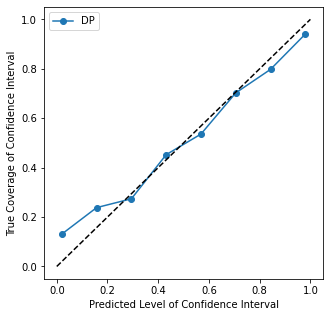

In [71]:
plt.plot(per,dpcrc,'o-',label='DP')
plt.xlabel('Predicted Level of Confidence Interval')
plt.ylabel('True Coverage of Confidence Interval')
plt.legend()
plt.plot([0,1],[0,1],'k--')
fig = plt.gcf()
fig.set_size_inches(5,5)
(np.array(dpcrc),np.abs(dpcrc-per).mean())

In [68]:
## recalculate loglikelihood
crinv= interp1d(proposep, truep)
l=(itv[id]-dpmu)/dpstd
r=(itv[id+1]-dpmu)/dpstd
prtmp=crinv(stats.norm.cdf(r))-crinv(stats.norm.cdf(l))
ll_est=np.log(prtmp+1.e-10)
ll_est.mean()

-1.4845645007910822

In [69]:
## interval width
dpcrwidth=np.median(dpstd)*(stats.norm.ppf(cr(per/2+0.5))-stats.norm.ppf(cr(-per/2+0.5)))/4.
dpcrwidth

array([0.01059238, 0.03397247, 0.05307014, 0.10291808, 0.14900459,
       0.29158475, 0.42979882, 0.89770179])

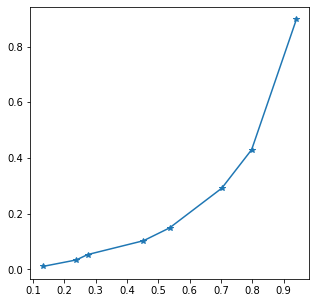

In [70]:
### sharpness plot
plt.figure(figsize=(5,5))
plt.plot(dpcrc,dpcrwidth,'-*')